In [117]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import ndimage
import random
from scipy.optimize import leastsq
from scipy import ndimage
from scipy.optimize import least_squares
from func import *
from scipy import stats
from matplotlib.colors import LogNorm

In [3]:
hdu = fits.open('/Volumes/Seagate/HE0040-1105 Extended/HE0040-1105.extended_cube.fits')
qso_data = hdu[0].data
qso_error = hdu[1].data
qso_header = hdu[0].header
#print(qso_header)
wavestart = qso_header['CRVAL3']
wavint = qso_header['CD3_3']
wave = wavestart+np.arange(qso_data.shape[0])*wavint#. This is the same as the one below.
qso_data[np.isnan(qso_data)] = 0.0000001
qso_error[np.isnan(qso_error)] = 0.000001
(central_y,central_x) = ndimage.measurements.maximum_position(qso_data[212,:,:])
print (central_x,central_y)

49 50


In [10]:
def BIC(data,model,n_free_par):
    N = len(data)
    BIC=stats.chisquare(data,model)[0] +n_free_par*(np.log(N) - np.log(2*np.pi))
    return BIC

In [11]:
z =0.04196
k = 1+z
c = 300000
central_vel = c*z
mini_data = qso_data
mini_error = qso_error
 
par = np.zeros((10,mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
err = np.zeros((10,mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
fitted = np.zeros((np.shape(wave)[0],mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
residuals = np.zeros((np.shape(wave)[0],mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
 
select_cont = (wave > 5070*k) & (wave < 5090*k)
select_OIII = (wave > 4997*k) & (wave <5017*k)
select_Hb = (wave > 4851*k) & (wave <4871*k)

In [5]:
for i in range(mini_data.shape[1]):
    for j in range(mini_data.shape[2]):
        x = wave  
        y = mini_data[:,i,j]
        y_err = mini_error[:,i,j]
        y_emission = mini_data[:,i,j][select_OIII] 
        
        amp_OIII = np.max(y[select_OIII])
        amp_Hb = np.max(y[select_Hb])
        
        y_cont = mini_data[:,i,j][select_cont]  
        S = np.mean(y_emission)
        N = np.std(y_cont)
                
        SN = S/N
     
        lower_bounds = [0,0,central_vel - 1000,0,0,0,central_vel - 1000,0,-np.inf,-np.inf]
        upper_bounds = [np.inf,np.inf,central_vel + 1000,600,np.inf,np.inf,central_vel + 1000,600,np.inf,np.inf]
        bounds_p_init = (lower_bounds,upper_bounds)
        
        try:    
            #(popt1,pcov1) = leastsq(full_gauss2_eline,x0=[0.1,0.2,central_vel,100,0.01,0.03,central_vel - 100,100,-0.001,0.002],args = (x,y,y_err),maxfev=10000000)
            result1 = least_squares(full_gauss_eline,bounds=bounds_p_init,x0=[amp_Hb,amp_OIII,central_vel,100,0.0,0.0,central_vel,0,0.0001,0.002],args = (x,y,y_err),max_nfev=10000000)
            popt1 = result1['x']
            model1 = full_gauss_eline(popt1,x,y,y_err)*(y_err)+y
            BIC1 = BIC(y,model1,6)

            result2 = least_squares(full_gauss2_eline,bounds=(lower_bounds,upper_bounds),x0=[0.7*amp_Hb,0.7*amp_OIII,central_vel,100,0.3*amp_Hb,0.3*amp_OIII,central_vel - 100,100,0.0001,0.002],args = (x,y,y_err),max_nfev=10000000)
            popt2 = result2['x']
            model2 = full_gauss2_eline(popt2,x,y,y_err)*(y_err)+y
            BIC2 = BIC(y,model2,10)
            
            if BIC2 - BIC1 > 2:
                popt = popt2
            else:
                popt = popt1
                
        except ValueError:
            popt = [0,0,central_vel,0,0,0,central_vel,0,0.00001,0.0002]
        
        par[:,i,j] = popt
        model = full_gauss2_eline(popt,x,y,y_err)*(y_err)+y
        fitted[:,i,j] = model      
        residuals[:,i,j] = mini_data[:,i,j] - fitted[:,i,j]
 
        print (i,j)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
1 100
2 0
2 1


15 43
15 44
15 45
15 46
15 47
15 48
15 49
15 50
15 51
15 52
15 53
15 54
15 55
15 56
15 57
15 58
15 59
15 60
15 61
15 62
15 63
15 64
15 65
15 66
15 67
15 68
15 69
15 70
15 71
15 72
15 73
15 74
15 75
15 76
15 77
15 78
15 79
15 80
15 81
15 82
15 83
15 84
15 85
15 86
15 87
15 88
15 89
15 90
15 91
15 92
15 93
15 94
15 95
15 96
15 97
15 98
15 99
15 100
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
16 11
16 12
16 13
16 14
16 15
16 16
16 17
16 18
16 19
16 20
16 21
16 22
16 23
16 24
16 25
16 26
16 27
16 28
16 29
16 30
16 31
16 32
16 33
16 34
16 35
16 36
16 37
16 38
16 39
16 40
16 41
16 42
16 43
16 44
16 45
16 46
16 47
16 48
16 49
16 50
16 51
16 52
16 53
16 54
16 55
16 56
16 57
16 58
16 59
16 60
16 61
16 62
16 63
16 64
16 65
16 66
16 67
16 68
16 69
16 70
16 71
16 72
16 73
16 74
16 75
16 76
16 77
16 78
16 79
16 80
16 81
16 82
16 83
16 84
16 85
16 86
16 87
16 88
16 89
16 90
16 91
16 92
16 93
16 94
16 95
16 96
16 97
16 98
16 99
16 100
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 1

29 17
29 18
29 19
29 20
29 21
29 22
29 23
29 24
29 25
29 26
29 27
29 28
29 29
29 30
29 31
29 32
29 33
29 34
29 35
29 36
29 37
29 38
29 39
29 40
29 41
29 42
29 43
29 44
29 45
29 46
29 47
29 48
29 49
29 50
29 51
29 52
29 53
29 54
29 55
29 56
29 57
29 58
29 59
29 60
29 61
29 62
29 63
29 64
29 65
29 66
29 67
29 68
29 69
29 70
29 71
29 72
29 73
29 74
29 75
29 76
29 77
29 78
29 79
29 80
29 81
29 82
29 83
29 84
29 85
29 86
29 87
29 88
29 89
29 90
29 91
29 92
29 93
29 94
29 95
29 96
29 97
29 98
29 99
29 100
30 0
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
30 21
30 22
30 23
30 24
30 25
30 26
30 27
30 28
30 29
30 30
30 31
30 32
30 33
30 34
30 35
30 36
30 37
30 38
30 39
30 40
30 41
30 42
30 43
30 44
30 45
30 46
30 47
30 48
30 49
30 50
30 51
30 52
30 53
30 54
30 55
30 56
30 57
30 58
30 59
30 60
30 61
30 62
30 63
30 64
30 65
30 66
30 67
30 68
30 69
30 70
30 71
30 72
30 73
30 74
30 75
30 76
30 77
30 78
30 79
30 80
30 81
30 82
30 83
3

42 92
42 93
42 94
42 95
42 96
42 97
42 98
42 99
42 100
43 0
43 1
43 2
43 3
43 4
43 5
43 6
43 7
43 8
43 9
43 10
43 11
43 12
43 13
43 14
43 15
43 16
43 17
43 18
43 19
43 20
43 21
43 22
43 23
43 24
43 25
43 26
43 27
43 28
43 29
43 30
43 31
43 32
43 33
43 34
43 35
43 36
43 37
43 38
43 39
43 40
43 41
43 42
43 43
43 44
43 45
43 46
43 47
43 48
43 49
43 50
43 51
43 52
43 53
43 54
43 55
43 56
43 57
43 58
43 59
43 60
43 61
43 62
43 63
43 64
43 65
43 66
43 67
43 68
43 69
43 70
43 71
43 72
43 73
43 74
43 75
43 76
43 77
43 78
43 79
43 80
43 81
43 82
43 83
43 84
43 85
43 86
43 87
43 88
43 89
43 90
43 91
43 92
43 93
43 94
43 95
43 96
43 97
43 98
43 99
43 100
44 0
44 1
44 2
44 3
44 4
44 5
44 6
44 7
44 8
44 9
44 10
44 11
44 12
44 13
44 14
44 15
44 16
44 17
44 18
44 19
44 20
44 21
44 22
44 23
44 24
44 25
44 26
44 27
44 28
44 29
44 30
44 31
44 32
44 33
44 34
44 35
44 36
44 37
44 38
44 39
44 40
44 41
44 42
44 43
44 44
44 45
44 46
44 47
44 48
44 49
44 50
44 51
44 52
44 53
44 54
44 55
44 56
44 57
44 58
44 5

56 67
56 68
56 69
56 70
56 71
56 72
56 73
56 74
56 75
56 76
56 77
56 78
56 79
56 80
56 81
56 82
56 83
56 84
56 85
56 86
56 87
56 88
56 89
56 90
56 91
56 92
56 93
56 94
56 95
56 96
56 97
56 98
56 99
56 100
57 0
57 1
57 2
57 3
57 4
57 5
57 6
57 7
57 8
57 9
57 10
57 11
57 12
57 13
57 14
57 15
57 16
57 17
57 18
57 19
57 20
57 21
57 22
57 23
57 24
57 25
57 26
57 27
57 28
57 29
57 30
57 31
57 32
57 33
57 34
57 35
57 36
57 37
57 38
57 39
57 40
57 41
57 42
57 43
57 44
57 45
57 46
57 47
57 48
57 49
57 50
57 51
57 52
57 53
57 54
57 55
57 56
57 57
57 58
57 59
57 60
57 61
57 62
57 63
57 64
57 65
57 66
57 67
57 68
57 69
57 70
57 71
57 72
57 73
57 74
57 75
57 76
57 77
57 78
57 79
57 80
57 81
57 82
57 83
57 84
57 85
57 86
57 87
57 88
57 89
57 90
57 91
57 92
57 93
57 94
57 95
57 96
57 97
57 98
57 99
57 100
58 0
58 1
58 2
58 3
58 4
58 5
58 6
58 7
58 8
58 9
58 10
58 11
58 12
58 13
58 14
58 15
58 16
58 17
58 18
58 19
58 20
58 21
58 22
58 23
58 24
58 25
58 26
58 27
58 28
58 29
58 30
58 31
58 32
58 33
58 3

70 41
70 42
70 43
70 44
70 45
70 46
70 47
70 48
70 49
70 50
70 51
70 52
70 53
70 54
70 55
70 56
70 57
70 58
70 59
70 60
70 61
70 62
70 63
70 64
70 65
70 66
70 67
70 68
70 69
70 70
70 71
70 72
70 73
70 74
70 75
70 76
70 77
70 78
70 79
70 80
70 81
70 82
70 83
70 84
70 85
70 86
70 87
70 88
70 89
70 90
70 91
70 92
70 93
70 94
70 95
70 96
70 97
70 98
70 99
70 100
71 0
71 1
71 2
71 3
71 4
71 5
71 6
71 7
71 8
71 9
71 10
71 11
71 12
71 13
71 14
71 15
71 16
71 17
71 18
71 19
71 20
71 21
71 22
71 23
71 24
71 25
71 26
71 27
71 28
71 29
71 30
71 31
71 32
71 33
71 34
71 35
71 36
71 37
71 38
71 39
71 40
71 41
71 42
71 43
71 44
71 45
71 46
71 47
71 48
71 49
71 50
71 51
71 52
71 53
71 54
71 55
71 56
71 57
71 58
71 59
71 60
71 61
71 62
71 63
71 64
71 65
71 66
71 67
71 68
71 69
71 70
71 71
71 72
71 73
71 74
71 75
71 76
71 77
71 78
71 79
71 80
71 81
71 82
71 83
71 84
71 85
71 86
71 87
71 88
71 89
71 90
71 91
71 92
71 93
71 94
71 95
71 96
71 97
71 98
71 99
71 100
72 0
72 1
72 2
72 3
72 4
72 5
72 6
72 7
72

84 16
84 17
84 18
84 19
84 20
84 21
84 22
84 23
84 24
84 25
84 26
84 27
84 28
84 29
84 30
84 31
84 32
84 33
84 34
84 35
84 36
84 37
84 38
84 39
84 40
84 41
84 42
84 43
84 44
84 45
84 46
84 47
84 48
84 49
84 50
84 51
84 52
84 53
84 54
84 55
84 56
84 57
84 58
84 59
84 60
84 61
84 62
84 63
84 64
84 65
84 66
84 67
84 68
84 69
84 70
84 71
84 72
84 73
84 74
84 75
84 76
84 77
84 78
84 79
84 80
84 81
84 82
84 83
84 84
84 85
84 86
84 87
84 88
84 89
84 90
84 91
84 92
84 93
84 94
84 95
84 96
84 97
84 98
84 99
84 100
85 0
85 1
85 2
85 3
85 4
85 5
85 6
85 7
85 8
85 9
85 10
85 11
85 12
85 13
85 14
85 15
85 16
85 17
85 18
85 19
85 20
85 21
85 22
85 23
85 24
85 25
85 26
85 27
85 28
85 29
85 30
85 31
85 32
85 33
85 34
85 35
85 36
85 37
85 38
85 39
85 40
85 41
85 42
85 43
85 44
85 45
85 46
85 47
85 48
85 49
85 50
85 51
85 52
85 53
85 54
85 55
85 56
85 57
85 58
85 59
85 60
85 61
85 62
85 63
85 64
85 65
85 66
85 67
85 68
85 69
85 70
85 71
85 72
85 73
85 74
85 75
85 76
85 77
85 78
85 79
85 80
85 81
85 82
8

97 90
97 91
97 92
97 93
97 94
97 95
97 96
97 97
97 98
97 99
97 100
98 0
98 1
98 2
98 3
98 4
98 5
98 6
98 7
98 8
98 9
98 10
98 11
98 12
98 13
98 14
98 15
98 16
98 17
98 18
98 19
98 20
98 21
98 22
98 23
98 24
98 25
98 26
98 27
98 28
98 29
98 30
98 31
98 32
98 33
98 34
98 35
98 36
98 37
98 38
98 39
98 40
98 41
98 42
98 43
98 44
98 45
98 46
98 47
98 48
98 49
98 50
98 51
98 52
98 53
98 54
98 55
98 56
98 57
98 58
98 59
98 60
98 61
98 62
98 63
98 64
98 65
98 66
98 67
98 68
98 69
98 70
98 71
98 72
98 73
98 74
98 75
98 76
98 77
98 78
98 79
98 80
98 81
98 82
98 83
98 84
98 85
98 86
98 87
98 88
98 89
98 90
98 91
98 92
98 93
98 94
98 95
98 96
98 97
98 98
98 99
98 100
99 0
99 1
99 2
99 3
99 4
99 5
99 6
99 7
99 8
99 9
99 10
99 11
99 12
99 13
99 14
99 15
99 16
99 17
99 18
99 19
99 20
99 21
99 22
99 23
99 24
99 25
99 26
99 27
99 28
99 29
99 30
99 31
99 32
99 33
99 34
99 35
99 36
99 37
99 38
99 39
99 40
99 41
99 42
99 43
99 44
99 45
99 46
99 47
99 48
99 49
99 50
99 51
99 52
99 53
99 54
99 55
99 56
99 5

In [6]:
hdus=[]
hdus.append(fits.PrimaryHDU())
hdus.append(fits.ImageHDU(par[0,:,:],name='amp_Hb'))
hdus.append(fits.ImageHDU(par[1,:,:],name='amp_OIII'))
hdus.append(fits.ImageHDU(par[2,:,:],name='vel_OIII'))
hdus.append(fits.ImageHDU(par[3,:,:],name='vel_sigma_OIII'))
hdus.append(fits.ImageHDU(par[4,:,:],name='amp_Hb_br'))
hdus.append(fits.ImageHDU(par[5,:,:],name='amp_OIII_br'))
hdus.append(fits.ImageHDU(par[6,:,:],name='vel_OIII_br'))
hdus.append(fits.ImageHDU(par[7,:,:],name='vel_sigma_OIII_br'))
hdus.append(fits.ImageHDU(par[8,:,:],name='m'))
hdus.append(fits.ImageHDU(par[9,:,:],name='c'))
hdu = fits.HDUList(hdus)

hdu.writeto('/Volumes/Seagate/HE0040-1105 Extended/subcube_par_HE0040-1105_extended_double_gauss.fits',overwrite=True)

In [34]:
filename = '/Volumes/Seagate/HE0040-1105 Extended/subcube_par_HE0040-1105_extended_fitted_residual_2Gauss.fits'
store_cube(filename,fitted,wave,residuals,qso_header)

from func import *

In [178]:
(xw,yw) = (65,57)
small_dat = qso_data[:,yw-2:yw+3,xw-2:xw+3]
small_err = qso_error[:,yw-2:yw+3,xw-2:xw+3]

In [179]:
c = 300000
z = 0.04196
(dat,err) = int_spec(small_dat,small_err)
central_vel = c*z

lower_bounds = [0,0,central_vel - 1000,0,0,0,central_vel - 1000,0,-np.inf,-np.inf]
upper_bounds = [np.inf,np.inf,central_vel + 1000,600,np.inf,np.inf,central_vel + 1000,600,np.inf,np.inf]
bounds_p_init = (lower_bounds,upper_bounds)

amp_OIII = np.max(dat[select_OIII])
amp_Hb = np.max(dat[select_Hb])   

x = wave
y = dat
y_err = err

In [180]:

result1 = least_squares(full_gauss_eline,bounds=bounds_p_init,x0=[amp_Hb,amp_OIII,central_vel,100,0.0,0.0,central_vel,0,0.0001,0.002],args = (x,y,y_err),max_nfev=10000000)
popt1 = result1['x']
model1 = full_gauss_eline(popt1,x,y,y_err)*(y_err)+y
BIC1 = BIC(y,model1,6)

result2 = least_squares(full_gauss2_eline,bounds=(lower_bounds,upper_bounds),x0=[0.7*amp_Hb,0.7*amp_OIII,central_vel,100,0.3*amp_Hb,0.3*amp_OIII,central_vel - 100,100,0.0001,0.002],args = (x,y,y_err),max_nfev=10000000)
popt2 = result2['x']
model2 = full_gauss2_eline(popt2,x,y,y_err)*(y_err)+y
BIC2 = BIC(y,model2,10)
            
if BIC2 - BIC1 > 10:
    popt = popt2
else:
    popt = popt1
    
print (popt)
model = full_gauss2_eline(popt,x,y,y_err)*(y_err)+y
core = Hb_O3_gauss(x,popt[0],popt[1],popt[2],popt[3]) + continuum(x,popt[8],popt[9])
wing = Hb_O3_gauss(x,popt[4],popt[5],popt[6],popt[7])+ continuum(x,popt[8],popt[9])

[ 1.81220186e-02  1.36753989e-01  1.24872633e+04  1.76359756e+02
  2.23802250e-02  3.64758661e-01  1.23464548e+04  1.65675784e-02
 -4.99846524e-03  3.07951872e-02]


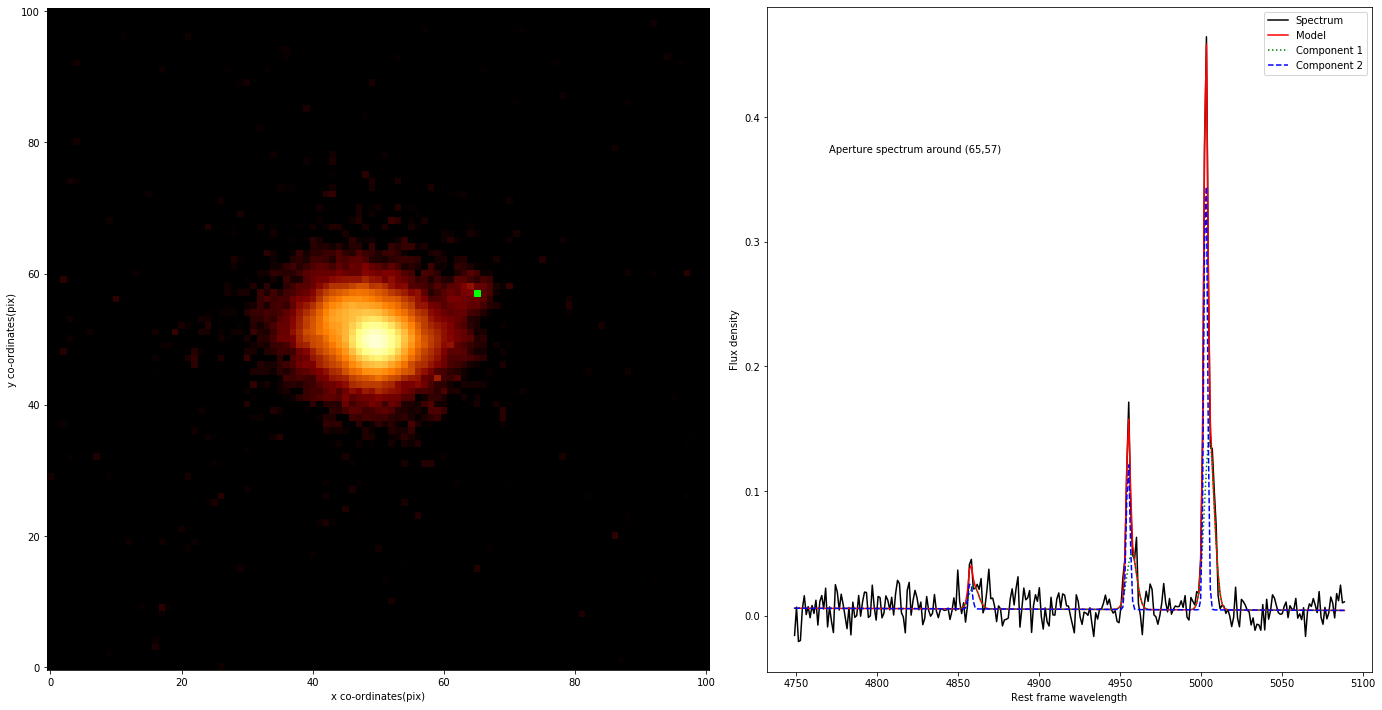

In [181]:
fig = plt.figure(figsize=(20,11))
ax1 = fig.add_axes([0.06, 0.1, 0.46, 0.84]) # main axes
ax2 = fig.add_axes([0.56, 0.1, 0.42, 0.84]) # main axes


pic_slice = qso_data[213,:,:]
pic_slice[pic_slice<1e-4] = 1e-15
ax1.imshow(pic_slice,origin='lower',interpolation='nearest',cmap='afmhot',norm=LogNorm(),vmin=0.003,vmax=3)
ax1.set_xlabel('x co-ordinates(pix)')
ax1.set_ylabel('y co-ordinates(pix)')

ax1.plot(xw,yw,'s',color='Lime')
ax2.plot(x/(1+z),dat,'k-',label='Spectrum')
ax2.plot(x/(1+z),model,'r-',label='Model')
ax2.plot(x/(1+z),core,'g:',label='Component 1')
ax2.plot(x/(1+z),wing,'b--',label='Component 2')
ax2.set_xlabel('Rest frame wavelength')
ax2.set_ylabel('Flux density')
ax2.text(4770,0.8*np.max(dat),'Aperture spectrum around (%s,%s)'%(xw,yw))
ax2.legend()
fig.savefig('/Volumes/Seagate/HE0040-1105 Extended/Coadded spectrum (5 pixels) around (%s,%s)'%(xw,yw),overwrite=True)